# Esp32-Cam Image Classification in 30 minutes


Have you ever wanted to perform **image classification** on your cheap Esp32-cam in a matter of minutes?

Do you want it to be easy and fast?

This project is for you!

Learn how to quickly implement your own **image classification system on the Esp32-cam** following 3 steps: 

 1. collect images from Esp32-cam to create a dataset
 2. train a Machine Learning classifier on your PC to classify images
 3. deploy that classifier to your Esp32-cam

*Image classification is the task of classifying an entire image as belonging to one of a given set of classes. It is not to be confused with **object detection**, which is the task of localizing objects of interest inside a given image.*

<x-object-detection.card></x-object-detection.card>

## Image Classification that is *Fast*

Image classification is not something entirely new on the Esp32-cam and other microcontrollers, thanks to [TensorFlow for Microcontrollers](https://www.tensorflow.org/lite/microcontrollers) and no-code platforms like [Edge Impulse](https://edgeimpulse.com).

They come with pre-trained Neural networks of varying size and complexity that you can leverage to implement your own image recognition system.

*But...*

**Neural Networks for image classification are heavyweight: they can take anywhere from 50 Kb to 500 Kb of RAM.**

Since your cheap Esp32-cam usually comes with limited RAM, you will often be forced to opt for a low complexity, low accuracy network.

Even more, with weight it comes **time complexity**: classifying an image on the Esp32-cam usually takes about 500 ms (*source: [Edge Impulse blog](https://www.edgeimpulse.com/blog/add-sight-to-your-esp32)*).

Can we do better?

Can we do *faster*?

Yes, we can!

**Image classification on Esp32-cam can be implemented in 30 minutes, with minimal code configuration, thanks to the Eloquent Arduino ecosystem of libraries: once deployed, it takes 1 kb of RAM and runs at 60 FPS.**

Follow the next steps to get up and running!

## Hardware Requirements

To follow this project the only requirement is an Esp32 camera.

You can find many models on the market:

 - [from Ai Thinker](http://www.ai-thinker.com/pro_view-24.html) (the most widely used)
 - [from Espressif](https://www.espressif.com/en/products/devkits/esp-eye/overview)
 - [from M5Stack](https://shop.m5stack.com/products/esp32-camera)

I can't recommend enough the cameras from M5Stack because they come with 4 Mb external PSRAM, but any from the above list should work.

<img src="assets/Esp32 cam devices.png" alt="Esp32 cam devices" />

## Software requirements

To capture the images from the Esp32-cam with ease, you need to install the **[EloquentEsp32Cam library](https://github.com/eloquentarduino/EloquentEsp32cam)**. It is available on the Arduino IDE Library Manager.

![Install EloquentEsp32Cam library](https://eloquentarduino.com/page-assets/esp32-camera-object-detection-eloquent-esp32cam-library.png)

To collect the images on your PC and train the Machine Learning model, you have to install the **[everywhereml Python package](https://github.com/eloquentarduino/everywhereml)**.

Create a new Python project and run

```bash
pip install everywhereml>=0.2.19
```

## Video walkthrough

In [15]:
from logging import basicConfig, INFO
from IPython.display import IFrame

basicConfig(level=INFO)
IFrame('https://www.youtube.com/embed/ZxRnVBiN_y4?rel=0', width=694, height=390)

## Step 1 of 5: Load the 4_Video_Feed.ino example sketch

First step to create a Machine Learning model is to collect data.

Since the Esp32-cam quality is pretty low, I recommend you to:

 1. fix the camera in position with tape and don't let it move
 2. use artificial illumination if possible (image quality degrades in low light conditions)
 
<img src="assets/esp32-cam image recognition setup.jpeg" alt="esp32-cam image recognition setup" />
<p class="caption">Something as simple as a plain background will work best</p>
 
To keep acquisition speed fast, we will capture at QQVGA resolution (160 x 120). If your project requires you to capture at higher resolutions, change the sketch accordingly.

<x-alerts.info>Image classification often happens at even lower resolutions anyway, so if you're not using the large version of the image for other purposes, QQVGA is the best choice</x-alerts.info>
 
Once your setup is ready, load the `4_Video_Feed.ino` example sketch from the EloquentEsp32Cam library examples. It is reported here for faster copy-paste.

Once loaded, the Esp32-cam will connect to your WiFi network and start an HTTP video streaming server you can access from any web broswer.

```cpp
#include "esp32cam.h"
#include "esp32cam/http/LiveFeed.h"

// Replace with your WiFi credentials
#define WIFI_SSID "SSID"
#define WIFI_PASS "PASSWORD"

// 80 is the port to listen to
// You can change it to whatever you want, 80 is the default for HTTP
Eloquent::Esp32cam::Cam cam;
Eloquent::Esp32cam::Http::LiveFeed feed(cam, 80);


void setup() {
    Serial.begin(115200);
    delay(3000);
    Serial.println("Init");

    /**
     * Configure camera model
     * Allowed values are:
     *  - aithinker()
     *  - m5()
     *  - m5wide()
     *  - eye()
     *  - wrover()
     */
    cam.aithinker();
    cam.highQuality();
    cam.qqvga();

    while (!cam.begin())
        Serial.println(cam.getErrorMessage());

    while (!cam.connect(WIFI_SSID, WIFI_PASS))
        Serial.println(cam.getErrorMessage());

    while (!feed.begin())
        Serial.println(feed.getErrorMessage());

    // make the camera accessible at http://esp32cam.local
    cam.viewAt("esp32cam");

    // display the IP address of the camera
    Serial.println(feed.getWelcomeMessage());
}


void loop() {
}
```

Open the Serial Monitor to take note of the IP address of the Esp32 camera.

If your router supports mDNS (most do), you won't need the IP address and will be able to use an easier (non changing) hostname.

To check if this is the case, click on the following link: [http://esp32cam.local](http://esp32cam.local)

If you can see the live video feed, it is working!

If not, either 1) your router does not support mDNS, 2) your PC is not connected to the same WiFi network as your Esp32.


**Close the window now, otherwise the next code won't work!**

**If you only see a frozen image (or no image at all) on Windows, you may have to disable your antivirus!**

## Step 2 of 5: Collect images from Esp32-cam over HTTP

Now that the Esp32-cam video stream is available over the WiFi network, we can run a program that collects the frames over HTTP.

We will make use of the `MjpegCollector` class, that needs the URL of the Esp32-cam web server (the one you can read on the Serial Monitor).

In [ ]:
"""
Collect images from Esp32-cam web server
"""
from logging import basicConfig, INFO
from everywhereml.data import ImageDataset
from everywhereml.data.collect import MjpegCollector

# you need to manually create this folder in the current working directory
base_folder = 'bords_over_http'
# copy here the address printed on the Serial Monitor
# (the one after "MJPEG stream available at")
IP_ADDRESS_OF_ESP = 'http://172.16.13.163:81'
basicConfig(level=INFO)

try:
    # if our dataset folder already exists, load it
    image_dataset = ImageDataset.from_nested_folders(
        name='Dataset', 
        base_folder=base_folder
    )
except FileNotFoundError:
    # if the dataset folder does not exists, collect the samples
    # from the Esp32-cam web server
    # duration is how long (in seconds) the program will collect 
    # the images for each class
    #
    # After each class collection, you may need to manually create the
    # subfolder to store the class images.
    #
    # Follow the instructions accurately!
    mjpeg_collector = MjpegCollector(address=IP_ADDRESS_OF_ESP)
    image_dataset = mjpeg_collector.collect_many_classes(
        dataset_name='Dataset', 
        base_folder=base_folder,
        duration=30
    )
  
print(image_dataset)

This is an interactive data capturing procedure.
Keep in mind that when you enter a class name, the capturing will start in 2 seconds, so be ready!
Which class are you going to capture? (leave empty to exit) no_board


  0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Captured 0 images


Is this class ok? (y|n) y


INFO:root:creating C:\Users\LENOVO\Downloads\bords_over_http folder
INFO:root:creating C:\Users\LENOVO\Downloads\bords_over_http\no_board folder


Which class are you going to capture? (leave empty to exit) sss


  0%|          | 0/100 [00:00<?, ?it/s]

The above snippet will start an interactive data collection procedure: it will ask for a class name and collect the frames for the given amount of time, until you decide to exit.

**First of all, enter `background` as class name and let the camera capture frames of nothing. If you skip this step, the model will ALWAYS try to classify the image, even if there's nothing in the scene!**.

**Next, put the objects you want to classify in front of the camera, enter the object name in the input field and press \[Enter\]. The frame collection will start after 2 seconds.**


<img src="assets/esp32-cam image recognition data collection.jpeg" alt="esp32-cam image recognition data collection" />
<p class="caption">Put the objects in front of the camera before starting the collection process</p>

**Move the object a little in front of the camera to capture slight variations and make the model more robust**.

Once you're done collecting frames, you can get a preview of them and check the quality of your work.

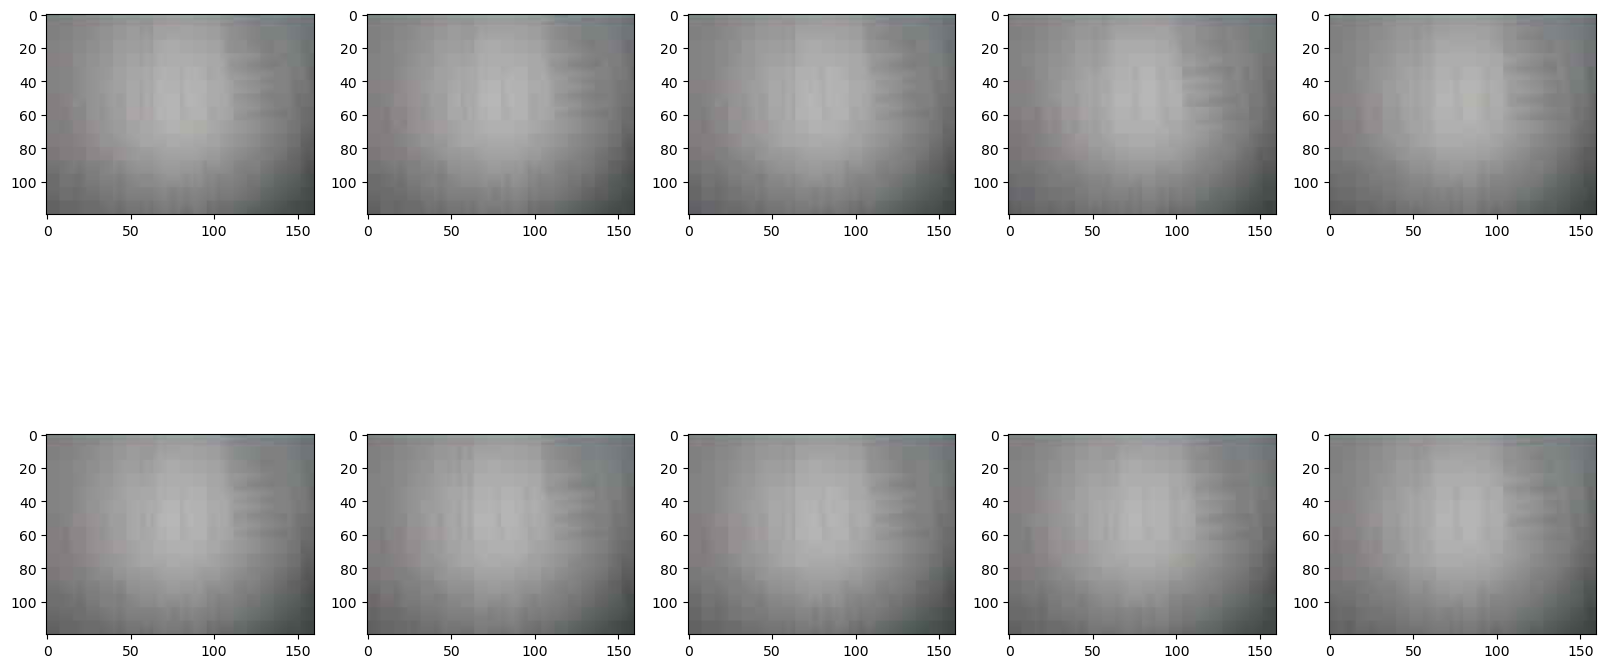

In [5]:
"""
Display a preview of the captured images
"""
image_dataset.preview(
    samples_per_class=10, 
    rows_per_class=2, 
    figsize=(20, 10)
)

If you find that some images are bad or totally wrong, take some time to delete them.

If you feel that you may need to capture more images, do so.

**Take all the time it takes to collect an high quality dataset, because in Machine Learning "garbage in, garbage out"!**

## Step 3 of 5: Create an Image Recognition pipeline

Having our very own dataset of images, we need a way to transform each image into something a Machine Learning model can classify.

With Neural Networks, you usually feed the raw image as input and the network learns by itself how to extract meaningful features from it.

With traditional Machine Learning it's different: we have to extract the features by ourself.

But don't worry, you don't have to do this on your own.

The `everywhereml` package has all the tools you need.

First of all, our feature extractor will work with grayscale images, so let's convert the dataset from RGB to Gray.

In [7]:
"""
Image classification with HOG works on grayscale images at the moment
So convert images to grayscale in the range 0-255
"""
image_dataset = image_dataset.gray().uint8()

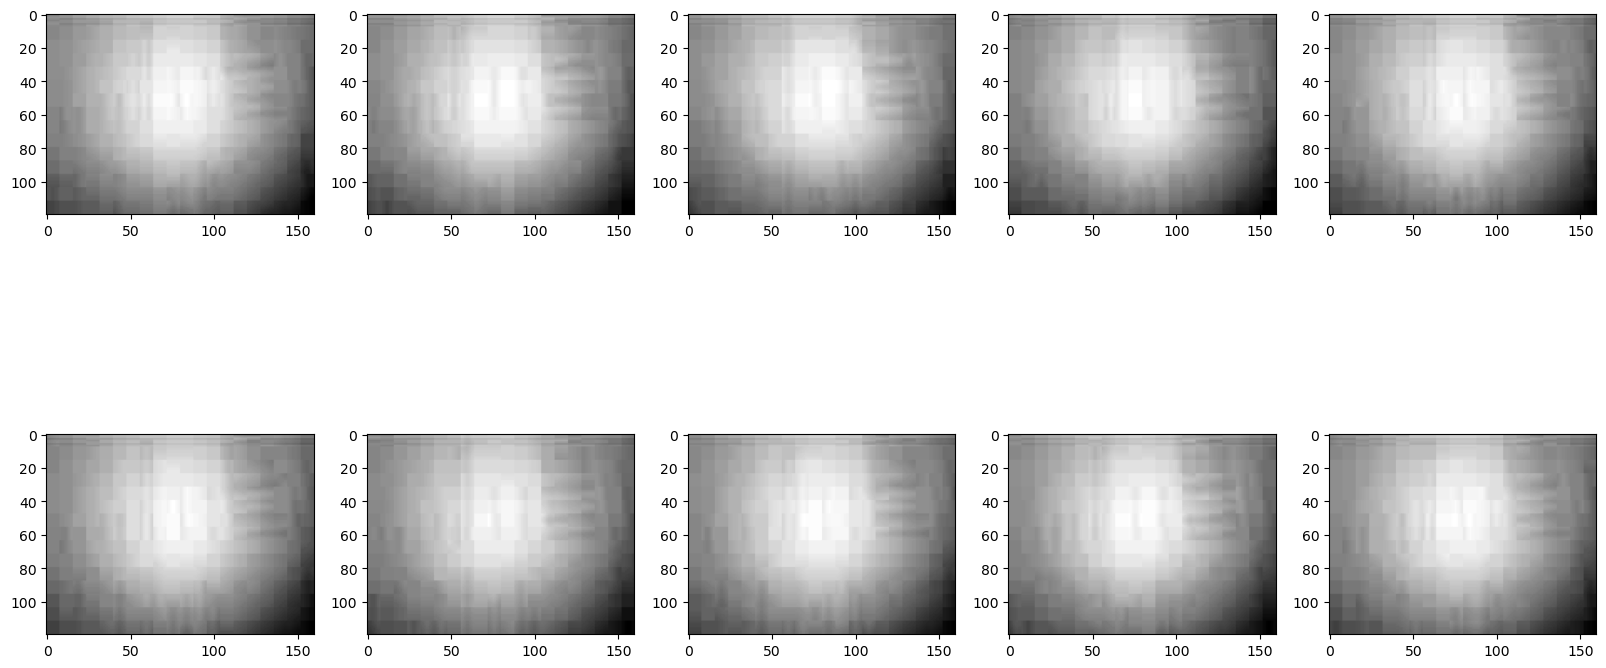

In [8]:
"""
Preview grayscale images
"""
image_dataset.preview(
    samples_per_class=10, 
    rows_per_class=2, 
    figsize=(20, 10), 
    cmap='gray'
)

Now it's time to actually convert the images to feature vectors.

There exist many feature extractor for images: in this project we will make use of [Histogram. of Oriented Gradients](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients).

It is lightweight and pretty fast, so it's a good fit for embedded environments like the Esp32-cam.

To speed the processing up, we will rescale our source image to a lower resolution (40 x 30).

If you later find your classifier achieves low accuracy, you may want to tweak this resolution and see how it impacts both accuracy and execution time.

In [9]:
"""
Create an image recognition pipeline with HOG feature extractor
"""
from everywhereml.preprocessing.image.object_detection import HogPipeline
from everywhereml.preprocessing.image.transform import Resize

pipeline = HogPipeline(
    transforms=[
        Resize(width=40, height=30)
    ]
)

# Convert images to feature vectors
feature_dataset = pipeline.fit_transform(image_dataset)
feature_dataset.describe()

HOG: 100%|██████████████████████████████████████████████████████████████████████████| 410/410 [00:00<00:00, 736.39it/s]


,hog0,hog1,hog2,hog3,hog4,hog5,hog6,hog7,hog8,hog9,...,hog126,hog127,hog128,hog129,hog130,hog131,hog132,hog133,hog134,target
count,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,...,410.0,410.0,410.0,410.0,410.0,410.000000,410.000000,410.000000,410.000000,410.0
mean,0.641647,0.820370,0.148696,0.009991,0.003498,0.004937,0.003677,0.000764,0.000080,0.271243,...,0.0,0.0,0.0,0.0,0.0,0.004081,0.155198,0.999935,0.126391,0.0
std,0.218408,0.169051,0.072070,0.016991,0.008950,0.010409,0.008185,0.003552,0.001147,0.096466,...,0.0,0.0,0.0,0.0,0.0,0.011094,0.082934,0.001312,0.065165,0.0
min,0.048777,0.268395,0.027925,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.973432,0.000000,0.0
25%,0.489868,0.704188,0.094137,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.214243,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.096535,1.000000,0.078651,0.0
50%,0.647181,0.844084,0.138950,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.285642,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.151909,1.000000,0.115717,0.0
75%,0.816081,1.000000,0.198589,0.019682,0.000000,0.000000,0.000000,0.000000,0.000000,0.327460,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.203951,1.000000,0.166908,0.0
max,1.000000,1.000000,0.414921,0.092354,0.047304,0.060908,0.036712,0.026825,0.017744,0.611064,...,0.0,0.0,0.0,0.0,0.0,0.062423,0.489541,1.000000,0.416607,0.0


In [10]:
"""
Print pipeline description
"""
print(pipeline)

ImagePipeline: HogPipeline
---------
 - Resize(from=(160, 120), to=(40, 30), pixformat=gray)
 > HOG(block_size=8, bins=9, cell_size=3)


The output of the above code is a dataset made of feature vectors, instead of images. These feature vectors are now suitable for Machine Learning models.

To get a *visual* idea of how informative the extracted features are, we can plot a *pairplot* of them.

A [pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html) compares each feature against the others in a grid format. By highlighting each class with a different color, you can quickly get if the features are able to "isolate" a class (if you can do this by eye, a Machine Learning classifier will be able too!).

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:108: RuntimeWarning: invalid value encountered in divide
  msb = ssbn / float(dfbn)


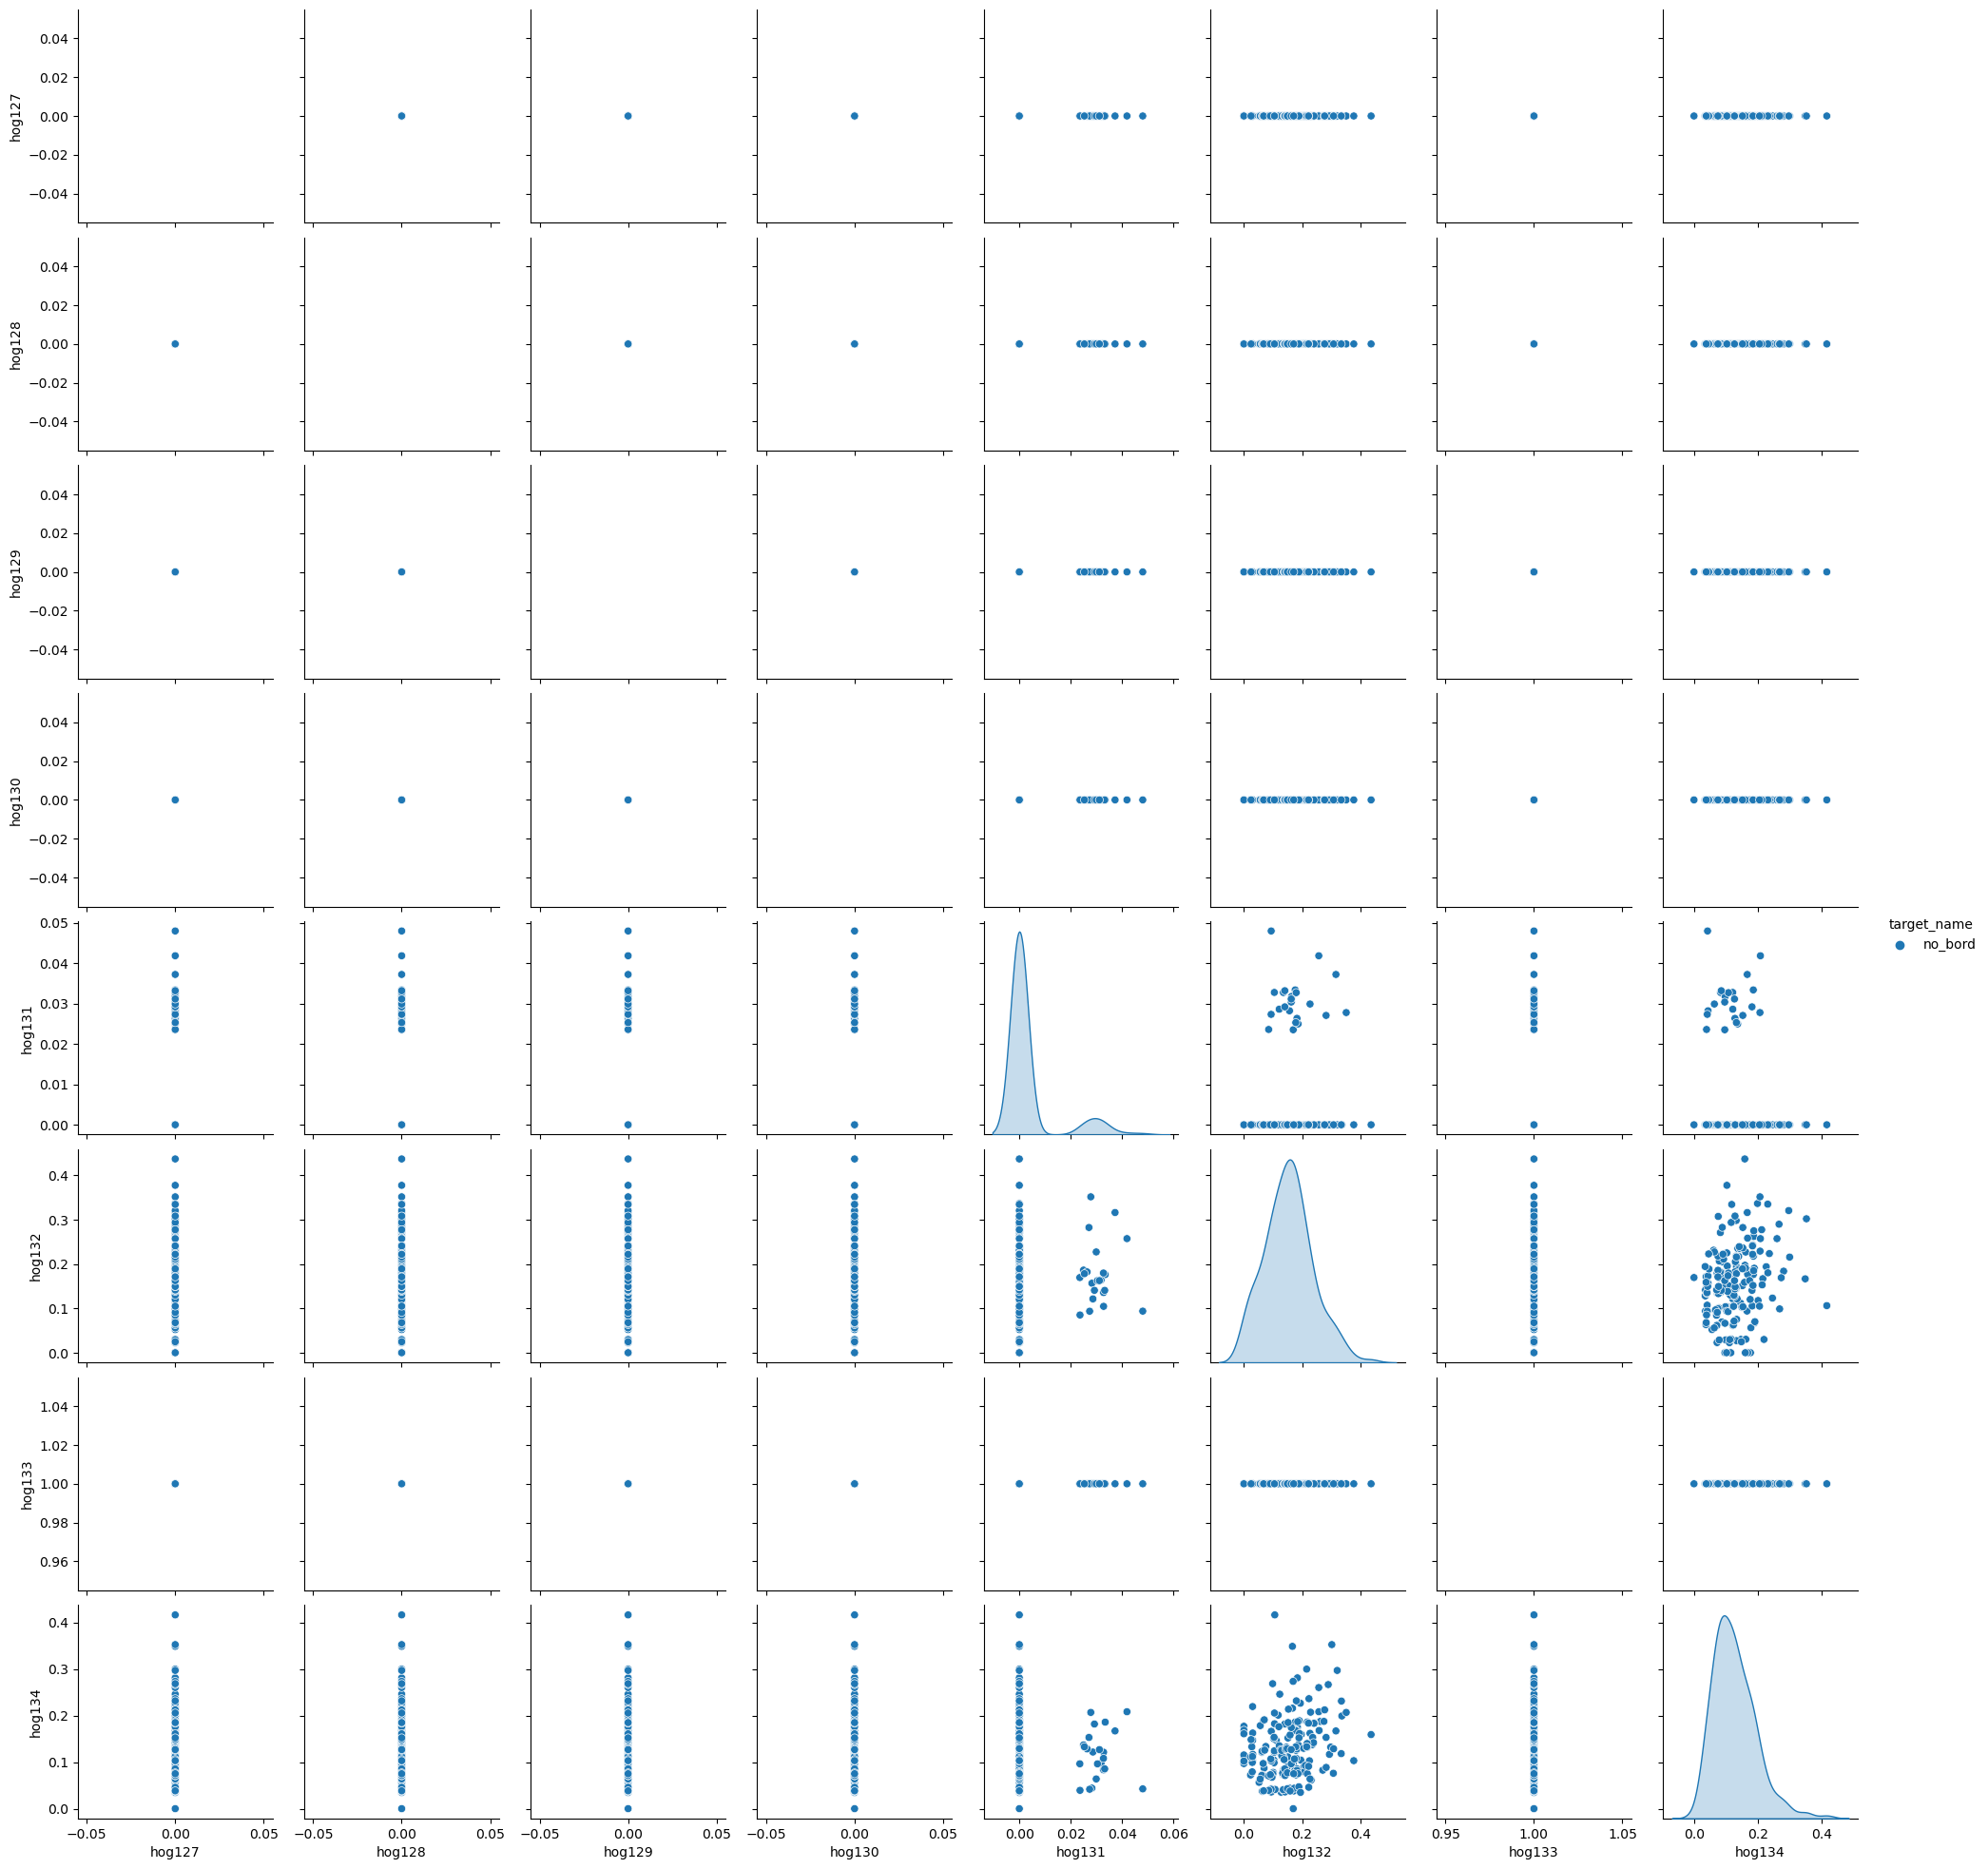

In [11]:
"""
Plot pairplot of features.
Feel free to open the image in a new window to see it at full scale.
In the next line:
 - n is the number of points to plot (the greater the value, the longer it takes)
 - k is the number of features (values greater than 10 become messy)
"""
feature_dataset.plot.features_pairplot(n=200, k=8)

In this case, we can clearly see that while the *wio* class and *empty* class are well clustered, the *pi* and *portenta* are always mixed to some degree.

This tells us that the classifier will mis-label them sometimes.

Another kind of visualization is UMAP.

[UMAP (Uniform Manifold Approximation and Projection)](https://umap-learn.readthedocs.io/en/latest/) is a dimensionality reduction algorithm.

It takes a feature vector of length N and "compresses" it to, in our case, length 2, while trying to preserve the topology structure of the original vector.

By collapsing the feature vectors to (x, y) pairs, we can plot them on a scatter plot.

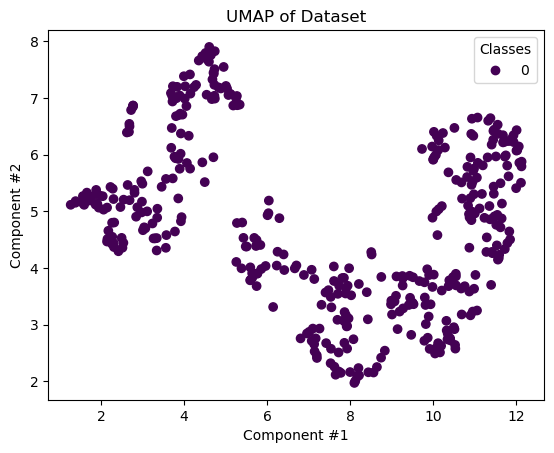

In [12]:
"""
Plot UMAP of features
If features are discriminative, we should see well defined clusters of points
"""
feature_dataset.plot.umap()

If we see well defined cluster of points (as in the above image), it means that our features do a great job at describing each class.

<x-alerts.info>If you feel like the pairplot and the UMAP "disagree", it is true only to some extent. UMAP applies heavy lifting to data to preserve the cluster isolation; most Machine Learning models won't do so. You should give more importance to the pairplot in the context of TinyML</x-alerts.info>

## Step 4 of 5: Train a Machine Learning classifier

From the above graphics we can say that our features are pretty good at characterizing our data, so it is time to train a classifier.

There are many available, but one of the most effective is [Random Forest](https://en.wikipedia.org/wiki/Random_forest). You can tweak its configuration as you prefer, but the values below should work fine in most cases.

In [23]:
"""
Create and fit RandomForest classifier
"""
from everywhereml.sklearn.ensemble import RandomForestClassifier

for i in range(10):
    clf = RandomForestClassifier(n_estimators=5, max_depth=10)

    # fit on train split and get accuracy on the test split
    train, test = feature_dataset.split(test_size=0.4, random_state=i)
    clf.fit(train)

    print('Score on test set: %.2f' % clf.score(test))

# now fit on the whole dataset
clf.fit(feature_dataset)

Score on test set: 1.00
Score on test set: 1.00
Score on test set: 1.00
Score on test set: 1.00
Score on test set: 1.00
Score on test set: 1.00
Score on test set: 1.00
Score on test set: 1.00
Score on test set: 1.00
Score on test set: 1.00


RandomForestClassifier(base_estimator=deprecated, bootstrap=True, ccp_alpha=0.0, class_name=RandomForestClassifier, class_weight=None, criterion=gini, estimator=DecisionTreeClassifier(), estimator_params=('criterion', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'min_weight_fraction_leaf', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'random_state', 'ccp_alpha'), max_depth=10, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None, num_outputs=4, oob_score=False, package_name=everywhereml.sklearn.ensemble, random_state=None, template_folder=everywhereml/sklearn/ensemble, verbose=0, warm_start=False)

Depending on your dataset, you can expect your accuracy to range from 0.7 to 1.

If it is lower (or too low for your use case), you can:

 1. improve your dataset (collect more images, fix your setup)
 2. tweak the `resize` parameter of the HogPipeline to an higher resolution
 3. tweak the `RandomForestClassifier` parameters ([see documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html))
 
If you're satisfied, it's time to port the whole system to your Esp32-cam.

## Step 5 of 5: Port to Esp32

Last step is to convert the `HogPipeline` and `RandomForestClassifier` to C++ code that can run on your Esp32-cam.

This process is very straightforward, since you only need a line of code.

Create a new project in the Arduino IDE to hold all the following files.

In [24]:
"""
Export pipeline to C++
Replace the path to your actual sketch path
"""
print(pipeline.to_arduino_file(
    filename='path-to-sketch/HogPipeline.h',
    instance_name='hog'
))

#ifndef UUID5351829856
#define UUID5351829856


    #ifndef UUID5351832016
#define UUID5351832016

/**
  * HOG(block_size=8, bins=9, cell_size=3)
 */
class HOG {
    public:

        /**
         * Transform input image
         */
         template<typename T, typename U>
        bool transform(T *input, U *output) {
            
    uint16_t f = 0;
    uint16_t block = 0;
    float hog[135] = {0};

    // compute gradients
    for (uint16_t blockY = 0; blockY < 3; blockY++) {
        const uint16_t blockOffsetY = blockY * 320;

        for (uint16_t blockX = 0; blockX < 5; blockX++) {
            const uint16_t blockOffsetX = blockX * 8;
            float hist[9] = {0};

            for (uint16_t _y = 1; _y < 7; _y += 1) {
                const uint16_t rowOffset = blockOffsetY + _y * 40 + blockOffsetX;
                const uint16_t rowOffsetBefore = rowOffset - 40;
                const uint16_t rowOffsetAfter = rowOffset + 40;

                for (uint16_t _x = 1; _x < 7; _x += 1

In [25]:
"""
Export classifier to C++
Replace the path to your actual sketch path

The class_map parameters convert numeric classes to human-readable strings
"""
print(clf.to_arduino_file(
    filename='path-to-sketch/HogClassifier.h',
    instance_name='classifier', 
    class_map=feature_dataset.class_map
))

#ifndef UUID5414136464
#define UUID5414136464

/**
  * RandomForestClassifier(base_estimator=deprecated, bootstrap=True, ccp_alpha=0.0, class_name=RandomForestClassifier, class_weight=None, criterion=gini, estimator=DecisionTreeClassifier(), estimator_params=('criterion', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'min_weight_fraction_leaf', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'random_state', 'ccp_alpha'), max_depth=10, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None, num_outputs=4, oob_score=False, package_name=everywhereml.sklearn.ensemble, random_state=None, template_folder=everywhereml/sklearn/ensemble, verbose=0, warm_start=False)
 */
class RandomForestClassifier {
    public:

        /**
         * Predict class from features
         */
        int predict(float *x) {
            int predictedValue = 0;
       

And this is the main code to put in the `.ino` file.


```cpp
#include "eloquent.h"
#include "eloquent/print.h"
#include "eloquent/tinyml/voting/quorum.h"

// replace 'm5wide' with your own model
// possible values are 'aithinker', 'eye', 'm5stack', 'm5wide', 'wrover'
#include "eloquent/vision/camera/aithinker.h"

#include "HogPipeline.h"
#include "HogClassifier.h"

Eloquent::TinyML::Voting::Quorum<7> quorum;


void setup() {
  Serial.begin(115200);
  delay(3000);
  Serial.println("Begin");

  camera.qqvga();
  camera.grayscale();

  while (!camera.begin())
    Serial.println("Cannot init camera");
}

void loop() {
  if (!camera.capture()) {
      Serial.println(camera.getErrorMessage());
      delay(1000);
      return;
  }
  
  // apply HOG pipeline to camera frame
  hog.transform(camera.buffer);

  // get a stable prediction
  // this is optional, but will improve the stability of predictions
  uint8_t prediction = classifier.predict(hog.features);
  int8_t stablePrediction = quorum.vote(prediction);

  if (quorum.isStable()) {
    eloquent::print::printf(
      Serial, 
      "Stable prediction: %s \t(DSP: %d ms, Classifier: %d us)\n", 
      classifier.getLabelOf(stablePrediction),
      hog.latencyInMillis(),
      classifier.latencyInMicros()
    );
  }

  camera.free();
}
```

Hit upload and put your objects in front of the camera: you will see the predicted label.

## Demo video

If you follow the above steps, you will end with the following result.

You can see that the *portenta* and *pi* are mis-labelled quite often: this is expected result as we saw from the features pairplot.

In [26]:
"""
Play demo video
"""
from IPython.display import Video

Video("assets/esp32 image object classification live demo.mp4", width=728)

Processing time is 12 milliseconds, while classification time is < 20 microseconds (1 / 1000 th of DSP!). If you do the math, this translates to **~80 FPS**, which is greater than your Esp32-cam frame rate.

<x-alerts.info>In the next release of <code>everywhereml</code>, thanks to some approximated math, DSP will lower to 6 milliseconds (a.k.a. <b>160 FPS!</b>)</x-alerts.info>

## Take your Esp32-cam skills to the next level!

Did this project got your attention?

Do you want to become an expert in the use of the Esp32-cam, but **you don't know where to start?**

Look no further, I have **the complete guide that you need**: it's called "Mastering the Esp32 Camera" and I'm writing it just now.

It will contain a more in-depth version of this image recognition project and much more:

 * Motion detection
 * Color blob detection
 * Passing people counter
 * Line crossing counter
 * Person detection
 * Face detection
 * TensorFlow YOLO
 * Edge Impulse 

You can buy the pre-sale right now (while I'm still writing it), which gives you access to:

 - **50% discount** on retail price (19,99$ when done)
 - **early access** to chapters drafts and code
 - **partecipate in polls and feature requests** to shape the contents of the book while I'm writing
 - **join the Discord community** with all the other people who bought this pre-sale

If you're hooked, don't wait more! Visit the dedicated page.

<a href="/mastering-the-esp32-camera" class="mt-4 block">
    <img src="/images/mastering-the-esp32-camera-popup-800x800.png" />
</a>

## Conclusion

When it comes to **image recognition on Esp32-cam**, you have two options:

 1. If you're looking for the best accuracy possibile, you should stick to Neural Networks: they achieve state-of-the-art results. Platforms like Edge Impulse will speed up your development time.
 2. If you're goal is to implement something that works *good* and **really fast**, you now have an alternative option to choose thanks to the Eloquent Arduino libraries.